# Combined CDOM and SST Analysis

This notebook demonstrates an end-to-end pipeline for processing satellite L2 RRS data to derive CDOM (Colored Dissolved Organic Matter) and MODIS L2P data for SST (Sea Surface Temperature). It then visualizes the SST, where the visibility (alpha/opacity) of the SST data is controlled by the concentration of CDOM. Higher CDOM concentrations will result in more visible SST. CDOM contours will also be overlaid. Using Mannino to compute CDOM 412_a

**Pipeline Steps:**

1.  **Import libraries** and set up the environment.
2.  **Define constants and parameters** for CDOM calculation, SST processing, shared geographical bounding box, and binning.
3.  **CDOM Processing:**
    *   Search for and load L2 RRS NetCDF files.
    *   Inspect RRS data.
    *   Extract RRS data (GPU accelerated).
    *   Calculate CDOM.
    *   Clip, bin, and interpolate CDOM data.
4.  **SST Processing:**
    *   Search for and load MODIS L2P SST NetCDF files.
    *   Inspect SST data.
    *   Extract SST data (GPU accelerated).
    *   Clip, bin, convert to Celsius, apply thresholds, and interpolate SST data to the same grid as CDOM.
5.  **Combined Plotting:**
    *   Plot SST, using its value for color.
    *   Modulate the opacity of the SST plot based on CDOM concentration.
    *   Overlay CDOM concentration contours.
    *   Include colorbars/legends for clarity.
6.  **(Optional) Plot individual raw CDOM and SST maps** for reference.

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and custom processing.

In [ ]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import matplotlib.colors
import cmocean # For specialized oceanographic colormaps

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))  # adds project_root to path

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib') # Ignore Matplotlib UserWarnings for set_bad

### Define Constants and Parameters

Define constants for CDOM calculation, SST processing, geographical area, binning, and data paths.

In [16]:
# --- Shared Geographical and Binning Parameters ---
# For combined analysis, a common bounding box is essential.
# Let's use a region that typically has both signals, e.g., Texas-Louisiana Shelf.
lon_min, lon_max = -95.0, -88.0 # Adjusted for potential overlap
lat_min, lat_max = 27.5, 30.5

lat_bins = 200 # Number of latitude bins (height)
lon_bins = 300 # Number of longitude bins (width)

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- L2 RRS Data Configuration (for CDOM) ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30"
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
interpolation_threshold_cdom = 32

# --- MODIS L2P Data Configuration (for SST) ---
data_dir_sst = r"E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30"
sst_variable_to_plot = 'sea_surface_temperature'
# For MODIS L2P, lat and lon are often 2D data variables.
sst_variables_to_load = [sst_variable_to_plot, 'lat', 'lon']
sst_data_group = None # Variables typically in root for MODIS L2P
min_sst_celsius_threshold = -2.0 # More realistic threshold for SST after Celsius conversion
interpolation_threshold_sst = 32

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins


## CDOM Data Processing

### Searching for L2 RRS Data Files (CDOM)

In [17]:
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files for CDOM processing.")
# nc_files_rrs = nc_files_rrs[:5] # Limiting for quick test
# print(f"Using {len(nc_files_rrs)} L2 RRS files.")

Found 42 L2 RRS files for CDOM processing.


### Inspecting Variables in L2 RRS Data (CDOM)

In [18]:
if nc_files_rrs:
    print(f"Inspecting variables in the first L2 RRS file: {nc_files_rrs[0]}")
    try:
        with xr.open_dataset(nc_files_rrs[0], group=rrs_data_group) as ds_geo:
            print(f"\nVariables in group: '{rrs_data_group}'")
            for var_name_ds in ds_geo.variables: print(f"  {var_name_ds}")
        with xr.open_dataset(nc_files_rrs[0], group='navigation_data') as ds_nav:
            print(f"\nVariables in group: 'navigation_data'")
            for var_name_ds in ds_nav.variables: print(f"  {var_name_ds}")
    except Exception as e:
        print(f"Error inspecting RRS file (or a group): {e}")
else:
    print("No L2 RRS NetCDF files found to inspect for CDOM.")

Inspecting variables in the first L2 RRS file: E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30\AQUA_MODIS.20240601T191500.L2.OC.nc

Variables in group: 'geophysical_data'
  aot_869
  angstrom
  Rrs_412
  Rrs_443
  Rrs_469
  Rrs_488
  Rrs_531
  Rrs_547
  Rrs_555
  Rrs_645
  Rrs_667
  Rrs_678
  chlor_a
  Kd_490
  pic
  poc
  ipar
  nflh
  par
  l2_flags

Variables in group: 'navigation_data'
  longitude
  latitude
  tilt


### Loading L2 RRS Datasets (CDOM)

In [19]:
datasets_rrs = []
if nc_files_rrs:
    try:
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets for CDOM.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load for CDOM.")

Successfully loaded 42 L2 RRS datasets for CDOM.


### GPU Data Extraction for L2 RRS (CDOM)

In [20]:
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction for CDOM complete. Extracted {len(lon_rrs_flat)} data points.")
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction for CDOM.")

L2 RRS data extraction for CDOM complete. Extracted 12725916 data points.


### CDOM Calculation

In [21]:
cdom_values = np.array([])
final_lon_cdom, final_lat_cdom, final_cdom_raw = np.array([]), np.array([]), np.array([])

if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    
    if Rss412.size > 0 and Rss555.size > 0 and Rss412.shape == lon_rrs_flat.shape and Rss555.shape == lon_rrs_flat.shape:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        
        cdom_values_temp = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values_temp[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        cdom_values = cdom_values_temp
        print(f"CDOM calculation complete. Min: {np.nanmin(cdom_values):.4f}, Max: {np.nanmax(cdom_values):.4f}")

        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
        final_lon_cdom = lon_rrs_flat[valid_mask]
        final_lat_cdom = lat_rrs_flat[valid_mask]
        final_cdom_raw = cdom_values[valid_mask]
        print(f"Filtered NaNs for CDOM data, {len(final_lon_cdom)} valid data points remaining.")
    else:
        print("Skipping CDOM calculation: Rrs_412 or Rrs_555 data not available, empty, or shape mismatch.")
else:
    print("Skipping CDOM data processing: No L2 RRS data extracted.")

CDOM calculation complete. Min: -inf, Max: 1.0487
Filtered NaNs for CDOM data, 12472520 valid data points remaining.


### Clipping, Binning, and Interpolating CDOM Data

In [22]:
binned_cdom_interpolated = np.array([[]])
lat_edges_grid, lon_edges_grid = None, None # To store grid edges for both CDOM and SST

if final_lon_cdom.size > 0:
    clip_mask_cdom = (
        (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
        (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
    )
    clipped_lon_cdom = final_lon_cdom[clip_mask_cdom]
    clipped_lat_cdom = final_lat_cdom[clip_mask_cdom]
    clipped_cdom_raw = final_cdom_raw[clip_mask_cdom]
    print(f"Clipped CDOM data to bounding box. {len(clipped_lon_cdom)} points remaining.")

    if clipped_lon_cdom.size > 0:
        binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, _ = binned_statistic_2d(
            clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
            statistic='mean', bins=[lat_bins, lon_bins], 
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for CDOM.")
        
        binned_cdom_interpolated = SelectiveInterpolator.interpolate(
            binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_cdom
        )
        print(f"Selective NaN interpolation complete for CDOM (threshold: {interpolation_threshold_cdom} bins).")
        if not np.any(~np.isnan(binned_cdom_interpolated)): print("Warning: Interpolated CDOM is all NaNs.")

    else:
        print("No CDOM data points within the bounding box to bin.")
        binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists
else:
    print("No valid CDOM data to clip, bin, or interpolate.")
    binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists

if lat_edges_grid is None or lon_edges_grid is None: # Create dummy grid if not made
    lat_edges_grid = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges_grid = np.linspace(lon_min, lon_max, lon_bins + 1)
    print("Warning: CDOM grid edges were not created from data; using linspace. Plotting might be affected if no data.")

Clipped CDOM data to bounding box. 844876 points remaining.
2D binning complete for CDOM.
Selective NaN interpolation complete for CDOM (threshold: 32 bins).


## SST Data Processing (MUR L4)

### Load MUR L4 SST Dataset using L3 Pipeline

In [23]:
# Use L3DatasetLoader to load MUR L4 SST
from l3_pipeline import L3DatasetLoader

data_dir_mur_l4 = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30"
mur_l4_files = glob.glob(os.path.join(data_dir_mur_l4, '*.nc'))
if not mur_l4_files:
    print(f"Warning: No MUR L4 files found in {data_dir_mur_l4}")
else:
    print(f"Found {len(mur_l4_files)} MUR L4 files.")

mur_l4_variable = 'analysed_sst'
l3_loader = L3DatasetLoader(variables=[mur_l4_variable], bbox=(lon_min, lon_max, lat_min, lat_max))
mur_l4_datasets = l3_loader.load_multiple(mur_l4_files)

if mur_l4_datasets:
    # For simplicity, use the first dataset (could be extended to combine multiple days)
    mur_l4_ds = mur_l4_datasets[0]
    mur_l4_sst = mur_l4_ds[mur_l4_variable].values
    mur_l4_lat = mur_l4_ds['lat'].values
    mur_l4_lon = mur_l4_ds['lon'].values
    # Convert SST from Kelvin to Celsius
    mur_l4_sst_celsius = mur_l4_sst - 273.15
    print(f"Loaded MUR L4 SST. Shape: {mur_l4_sst_celsius.shape}, Range: {np.nanmin(mur_l4_sst_celsius):.2f} to {np.nanmax(mur_l4_sst_celsius):.2f} °C")
else:
    mur_l4_sst_celsius = np.full((lat_bins, lon_bins), np.nan)
    mur_l4_lat = np.linspace(lat_min, lat_max, lat_bins)
    mur_l4_lon = np.linspace(lon_min, lon_max, lon_bins)
    print("No valid MUR L4 SST data loaded.")

Found 31 MUR L4 files.


f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

Loaded MUR L4 SST. Shape: (1, 301, 701), Range: 26.36 to 28.97 °C


### Normalize MUR L4 SST for Combined Product

In [24]:
# Normalize MUR L4 SST (e.g., 20°C→1, 28°C→0, clamp to [0,1])
def index_sst_maps(data_array, sst_min, sst_max):
    original_nans = np.isnan(data_array)
    indexed = (sst_max - data_array) / (sst_max - sst_min)
    indexed = np.clip(indexed, 0, 1)
    indexed[original_nans] = np.nan
    return indexed

sst_indexed = index_sst_maps(mur_l4_sst_celsius, sst_min=24, sst_max=28)
print(f"Indexed MUR L4 SST: {np.nanmin(sst_indexed):.4f} to {np.nanmax(sst_indexed):.4f}")

Indexed MUR L4 SST: 0.0000 to 0.4112


### Combine with CDOM and Plot

In [25]:
# Ensure CDOM and SST grids are compatible (interpolate CDOM if needed)
from scipy.interpolate import griddata

if binned_cdom_interpolated.shape != mur_l4_sst_celsius.shape:
    # Interpolate CDOM to MUR L4 grid
    cdom_lat_centers = (lat_edges_grid[:-1] + lat_edges_grid[1:]) / 2
    cdom_lon_centers = (lon_edges_grid[:-1] + lon_edges_grid[1:]) / 2
    cdom_lon_mesh, cdom_lat_mesh = np.meshgrid(cdom_lon_centers, cdom_lat_centers)
    mur_lon_mesh, mur_lat_mesh = np.meshgrid(mur_l4_lon, mur_l4_lat)
    cdom_interp_flat = griddata(
        (cdom_lat_mesh.flatten(), cdom_lon_mesh.flatten()),
        binned_cdom_interpolated.flatten(),
        (mur_lat_mesh, mur_lon_mesh),
        method='linear',
        fill_value=np.nan
    )
    cdom_for_combined = cdom_interp_flat
else:
    cdom_for_combined = binned_cdom_interpolated

# Normalize CDOM using the custom function (0.01->0, 0.16->1)
def normalize_cdom_custom(data_array, cdom_min=0.01, cdom_max=0.16):
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

cdom_normalized = normalize_cdom_custom(cdom_for_combined, cdom_min=0.01, cdom_max=0.16)
print(f"Normalized CDOM (custom): {np.nanmin(cdom_normalized):.4f} to {np.nanmax(cdom_normalized):.4f}")

# Multiply the two normalized maps
combined_product = cdom_normalized * sst_indexed
print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")

Normalized CDOM (custom): 0.0000 to 1.0000
Combined product range: 0.0000 to 0.4112


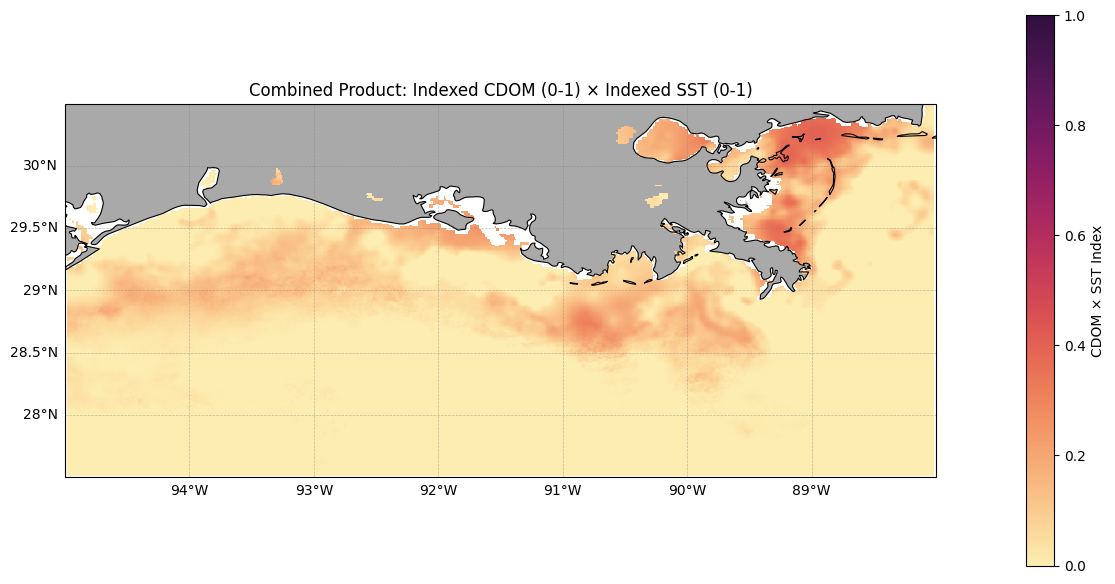

In [26]:
# Plot the combined product with correct bin edges
def get_bin_edges_from_centers(centers):
    # Assumes centers are sorted
    diffs = np.diff(centers)
    edges = np.concatenate(([centers[0] - diffs[0]/2],
                            centers[:-1] + diffs/2,
                            [centers[-1] + diffs[-1]/2]))
    return edges

# If mur_l4_lat/lon are 1D (typical for L3), get edges
if mur_l4_lat.ndim == 1 and mur_l4_lon.ndim == 1:
    lat_edges = get_bin_edges_from_centers(mur_l4_lat)
    lon_edges = get_bin_edges_from_centers(mur_l4_lon)
    # Ensure combined_product shape matches (len(lat_edges)-1, len(lon_edges)-1)
    if combined_product.shape != (len(mur_l4_lat), len(mur_l4_lon)):
        print(f"Warning: combined_product shape {combined_product.shape} does not match grid ({len(mur_l4_lat)}, {len(mur_l4_lon)})")
    plot_lat_edges = lat_edges
    plot_lon_edges = lon_edges
else:
    # If 2D, use as is
    plot_lat_edges = mur_l4_lat
    plot_lon_edges = mur_l4_lon

# --- FIX: Squeeze singleton dimension if present ---
combined_product = np.squeeze(combined_product)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([mur_l4_lon[0], mur_l4_lon[-1], mur_l4_lat[0], mur_l4_lat[-1]], crs=ccrs.PlateCarree())

comb_vmin, comb_vmax = 0, 1

combined_plot = ax.pcolormesh(plot_lon_edges, plot_lat_edges, combined_product,
                            cmap=cmocean.cm.matter, shading='auto',
                            vmin=comb_vmin, vmax=comb_vmax, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = fig.colorbar(combined_plot, ax=ax, label='CDOM × SST Index', shrink=0.7, pad=0.08)

plt.title("Combined Product: Indexed CDOM (0-1) × Indexed SST (0-1)", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

### Compare Raw vs Indexed SST and CDOM (MUR L4)

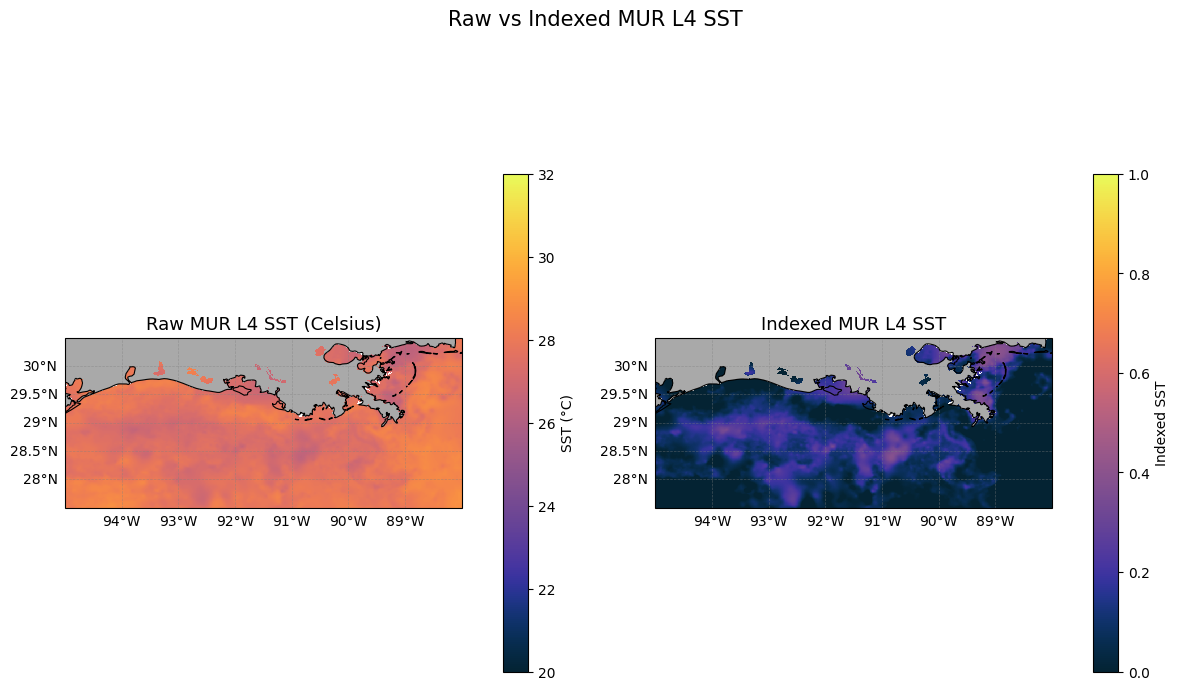

In [27]:
# --- Raw SST vs Indexed SST (MUR L4) ---
fig, axes = plt.subplots(1, 2, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})

# Raw SST
ax1 = axes[0]
ax1.set_extent([mur_l4_lon[0], mur_l4_lon[-1], mur_l4_lat[0], mur_l4_lat[-1]], crs=ccrs.PlateCarree())
sst_vmin, sst_vmax = 20, 32
p1 = ax1.pcolormesh(mur_l4_lon, mur_l4_lat, np.squeeze(mur_l4_sst_celsius),
                    cmap=cmocean.cm.thermal, shading='auto',
                    vmin=sst_vmin, vmax=sst_vmax, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
fig.colorbar(p1, ax=ax1, label='SST (°C)', shrink=0.7, pad=0.08)
ax1.set_title('Raw MUR L4 SST (Celsius)', fontsize=13)

# Indexed SST
ax2 = axes[1]
ax2.set_extent([mur_l4_lon[0], mur_l4_lon[-1], mur_l4_lat[0], mur_l4_lat[-1]], crs=ccrs.PlateCarree())
sst_idx_vmin, sst_idx_vmax = 0, 1
p2 = ax2.pcolormesh(mur_l4_lon, mur_l4_lat, np.squeeze(sst_indexed),
                    cmap=cmocean.cm.thermal, shading='auto',
                    vmin=sst_idx_vmin, vmax=sst_idx_vmax, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
fig.colorbar(p2, ax=ax2, label='Indexed SST', shrink=0.7, pad=0.08)
ax2.set_title('Indexed MUR L4 SST', fontsize=13)

plt.suptitle('Raw vs Indexed MUR L4 SST', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

TypeError: Dimensions of C (301, 701) should be one smaller than X(301) and Y(201) while using shading='flat' see help(pcolormesh)

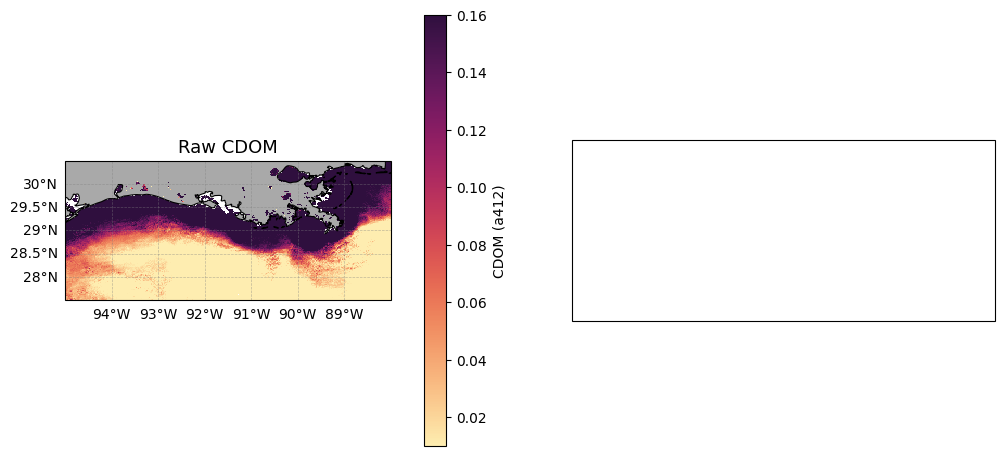

In [28]:
# --- Raw CDOM vs Indexed CDOM ---
fig, axes = plt.subplots(1, 2, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})

# Raw CDOM
ax1 = axes[0]
ax1.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())
cdom_vmin, cdom_vmax = 0.01, 0.16
p1 = ax1.pcolormesh(lon_edges_grid, lat_edges_grid, binned_cdom_interpolated,
                    cmap=cmocean.cm.matter, shading='auto',
                    vmin=cdom_vmin, vmax=cdom_vmax, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
fig.colorbar(p1, ax=ax1, label='CDOM (a412)', shrink=0.7, pad=0.08)
ax1.set_title('Raw CDOM', fontsize=13)

# Indexed CDOM
ax2 = axes[1]
ax2.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())
cdom_idx_vmin, cdom_idx_vmax = 0, 1
p2 = ax2.pcolormesh(lon_edges_grid, lat_edges_grid, cdom_normalized,
                    cmap=cmocean.cm.matter, shading='auto',
                    vmin=cdom_idx_vmin, vmax=cdom_idx_vmax, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
fig.colorbar(p2, ax=ax2, label='Indexed CDOM (0.01→0, 0.16→1)', shrink=0.7, pad=0.08)
ax2.set_title('Indexed CDOM', fontsize=13)

plt.suptitle('Raw CDOM vs Indexed CDOM', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()